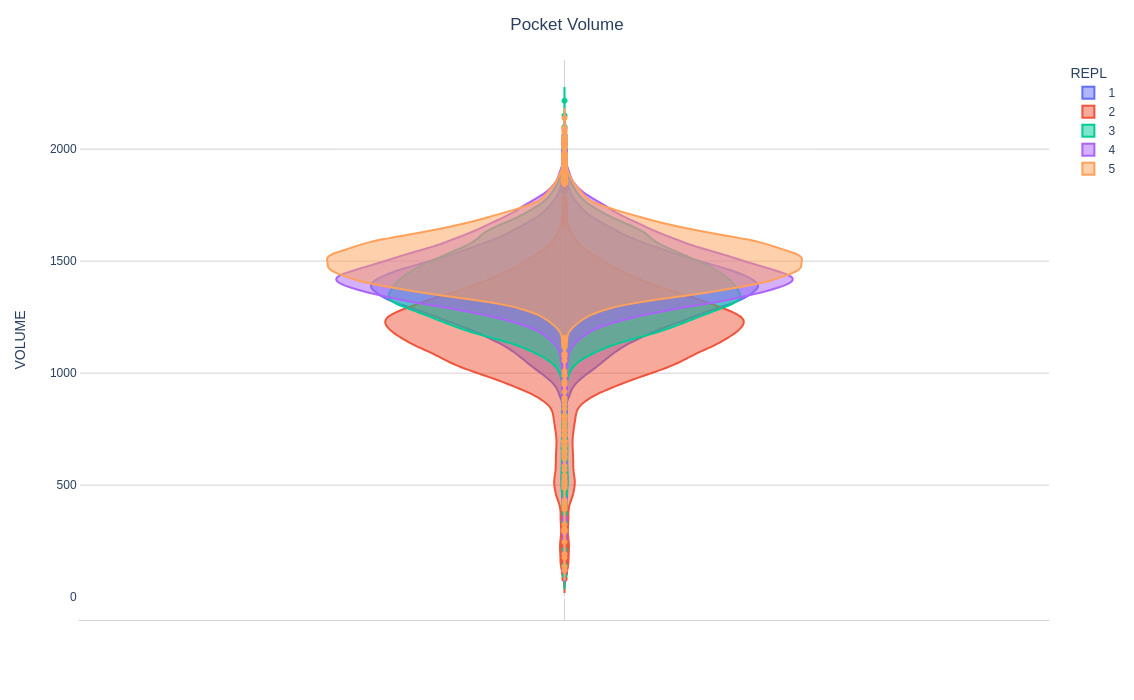

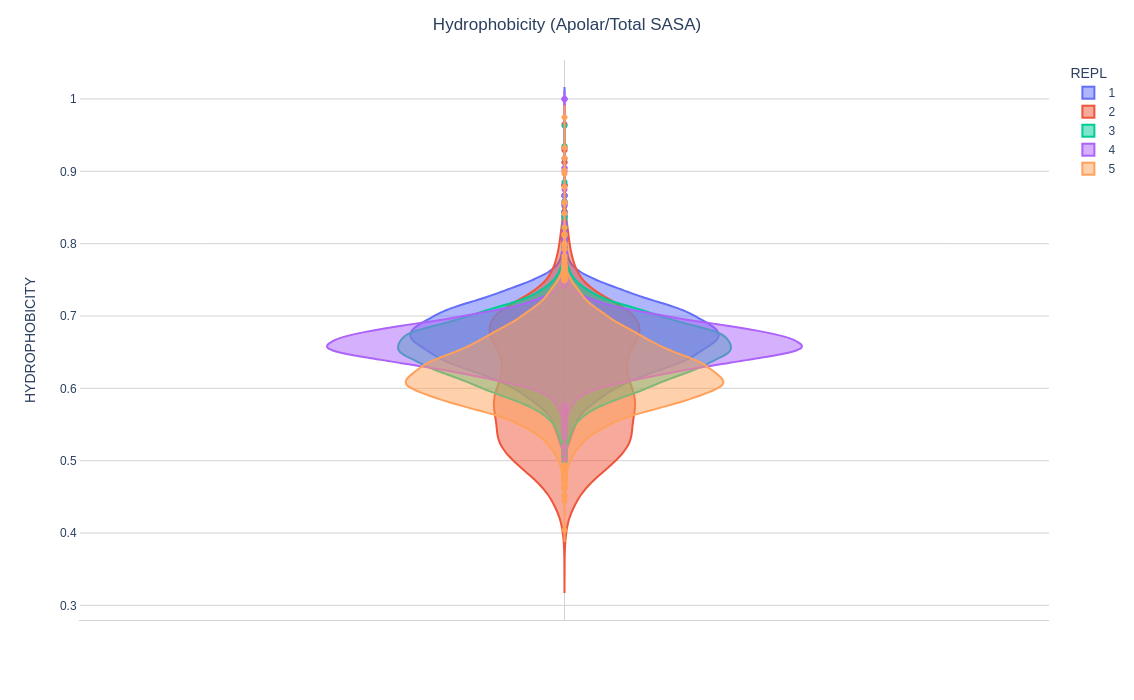

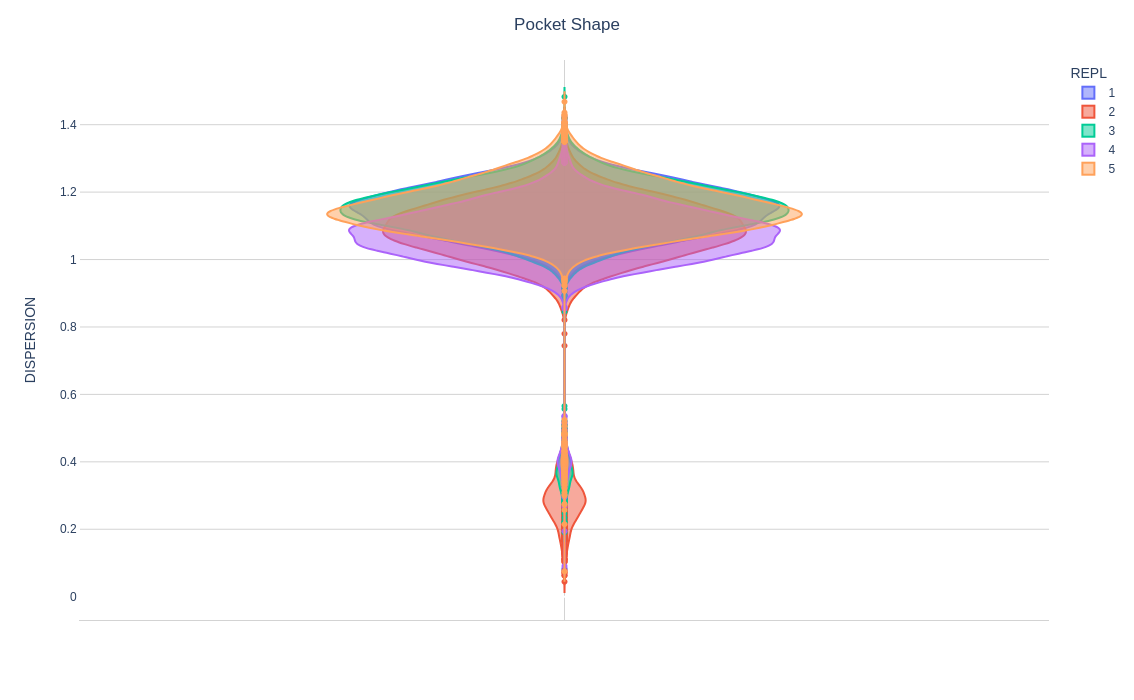

Average of median values for volume: 1381.18 +/- 102.69

Average of median values for hydrophobicity (Apolar/Total SASA): 0.64 +/- 0.02

Average of median values for dispersion (shape): 1.12 +/- 0.03

Average min-max difference for volume: 1962.11 +/- 114.91



In [7]:
import numpy as np
import pandas as pd
import plotly.express as px

# Function to parse and extract data from file paths with updated hydrophobicity calculation
def parse_data(file_mdpocket, file_fpocket, num_entries=12500):
    """
    Parses mdpocket and fpocket descriptor files and returns lists of volume, hydrophobicity (apolar SASA/total SASA), and dispersion (shape).
    """
    # Extract data from mdpocket
    with open(file_mdpocket, "r") as f:
        mdpocket_data = [line.split() for line in f]
    
    volume_mdpocket = []
    sasa_mdpocket = []
    apolar_sasa_mdpocket = []
    
    for i in range(1, num_entries):
        volume_mdpocket.append(float(mdpocket_data[i][1]))
        sasa_mdpocket.append(float(mdpocket_data[i][2]))
        apolar_sasa_mdpocket.append(float(mdpocket_data[i][4]))
    
    # Extract data from fpocket
    with open(file_fpocket, "r") as f:
        fpocket_data = [line.split() for line in f]
    
    volume_fpocket = []
    sasa_fpocket = []
    apolar_sasa_fpocket = []
    
    for i in range(1, num_entries):
        volume_fpocket.append(float(fpocket_data[i][1]))
        sasa_fpocket.append(float(fpocket_data[i][3]))
        apolar_sasa_fpocket.append(float(fpocket_data[i][4]))
    
    # Compute hydrophobicity as apolar SASA / total SASA, along with volume and dispersion
    hydrophobicity_sasa, volume, dispersion = [], [], []
    
    for i in range(num_entries - 1):
        if volume_fpocket[i] < volume_mdpocket[i]:
            hydrophobicity_sasa.append(apolar_sasa_fpocket[i] / sasa_fpocket[i])
            volume.append(volume_fpocket[i])
            dispersion.append(sasa_fpocket[i] / volume_fpocket[i] / (3 / (3 * volume_fpocket[i] / (4 * np.pi)) ** (1/3)))
        else:
            hydrophobicity_sasa.append(apolar_sasa_mdpocket[i] / sasa_mdpocket[i])
            volume.append(volume_mdpocket[i])
            dispersion.append(sasa_mdpocket[i] / volume_mdpocket[i] / (3 / (3 * volume_mdpocket[i] / (4 * np.pi)) ** (1/3)))
    
    return hydrophobicity_sasa, volume, dispersion

# General function to calculate median and standard deviation for a given property
def calculate_statistics(property_list, label):
    property_arrays = [np.array(prop) for prop in property_list]
    medians = np.median(property_arrays, axis=1)
    std_dev = np.std(medians)
    median_avg = np.mean(medians)
    
    print(f"Average of median values for {label}: {median_avg:.2f} +/- {std_dev:.2f}")
    print()

# Function to calculate and print min-max difference for volume
def calculate_min_max_difference_volume(volume_list):
    volume_arrays = [np.array(vol) for vol in volume_list]
    min_max_diff = [np.max(vol) - np.min(vol) for vol in volume_arrays]
    avg_diff = np.mean(min_max_diff)
    std_diff = np.std(min_max_diff)
    
    print(f"Average min-max difference for volume: {avg_diff:.2f} +/- {std_diff:.2f}")
    print()

# Function to generate violin plots
def generate_violin_plot(data, property_name, title):
    df = pd.DataFrame({property_name.upper(): data, 'REPL': list_numbers})
    fig = px.violin(df, y=property_name.upper(), color='REPL', violinmode='overlay', width=1000, height=700)
    fig.update_layout(
        title=title,
        title_x=0.5,
        plot_bgcolor='white',
        yaxis=dict(showline=True, gridcolor='lightgray'),
        xaxis=dict(showline=True, gridcolor='lightgray', linecolor="lightgray"),
        yaxis_showgrid=True,
        xaxis_showgrid=True
    )
    fig.show()

# Paths to files and names for different replicates
name = "human_cyps/CYP3A4/5VC0"
replicates = [f"/pool/teakuvek/CYPs/{name}/md/repl{i}/gmx" for i in range(1, 6)]
mdpocket_files = [f"{rep}/mdpocket/mdpout_descriptors.txt" for rep in replicates]
fpocket_files = [f"{rep}/frames/fpocket_sasa.txt" for rep in replicates]

# Parse data for each replicate
hydrophobicity_data, volume_data, dispersion_data = [], [], []
for mdpocket_file, fpocket_file in zip(mdpocket_files, fpocket_files):
    hydro, vol, disp = parse_data(mdpocket_file, fpocket_file)
    hydrophobicity_data.append(hydro)
    volume_data.append(vol)
    dispersion_data.append(disp)

# Generate violin plots for volume, hydrophobicity (calculated as apolar/total SASA), and dispersion
list_numbers = []
for i in range(1, 6):
    list_numbers.extend([i] * len(volume_data[i-1]))

generate_violin_plot([item for sublist in volume_data for item in sublist], 'volume', 'Pocket Volume')
generate_violin_plot([item for sublist in hydrophobicity_data for item in sublist], 'hydrophobicity', 'Hydrophobicity (Apolar/Total SASA)')
generate_violin_plot([item for sublist in dispersion_data for item in sublist], 'dispersion', 'Pocket Shape')

# Calculate statistics
calculate_statistics(volume_data, 'volume')
calculate_statistics(hydrophobicity_data, 'hydrophobicity (Apolar/Total SASA)')
calculate_statistics(dispersion_data, 'dispersion (shape)')

# Calculate min-max difference for volume only
calculate_min_max_difference_volume(volume_data)



